# DVTUP value-based data valuation framework demo
The objective of this notebook is to show the functionality of the DVTUP module in PIMCITY in order to calculate the value of different sources contributing to a prediction model by using the different methodologies described in the deliverable, namely the following:
- individual-value (0),
- LOO value (1),
- Exact Shapley value (2),
- (Truncated) Montecarlo (MC) approximation to Shapley value (3),
- (Truncated) Structured sampling (SS) approximation to Shapley value (4),
- (Truncated) Random sampling (RS) approximation to Shapley value (5)

We use HCDE value-based data evaluation framework, which is a python library that allows PIMS and data marketplaces to calculate the value of dataset and data sources based on the value they actually bring to a specific AI/ML algorithm.

We will set up a framework to work with a SARIMA multiseasonal model in order to predict traffic in the city of Chicago at community level. This specific version of the model is added a restriction to prevent negative values in the prediction model. In this first version of the DVTUP models will be fed by external data. In future versions, data will be retrieved from PIMCITY's P-DS and preprocessed to meet the requirements of the specific model.

The structure of the notebook will be the following:
1. We will introduce the SARIMA model and test it using the abstractions defined in the framework
2. We will provide examples about how to calculate valuations using the different functions

## Model Specifications

We will use a multiseasonal SARIMA model as defined in the article [Computing the Value of Spatio-Temporal Data in Wholesale and Retail Data Marketplaces](https://arxiv.org/abs/2002.11193). The particular characteristics of the model are as follows:
* Multiseasonal SARIMA with daily and weekly double periodicity
* Additive sum of average daily component and hourly difference
* Corrects 
* $T_o = $2/04/2019 - 3/17/2019
* $T_c = $3/18/2019 - 3/31/2019
* Parameters to feed the SARIMA model were selected using a grid search analysis with depth 2:
  * For the daily model $(1,1,1)x(1,1,1)^7$ (weekly periodicity)
  * For the hourly model $(1,0,1)x(1,0,1)^{24}$ (daily periodicity)
  
In order to measure the accuracy of the predictions given by the model, we will use inverse of some distance metrics applied to normalized signals:
* Cosine Similarity
* Cross correlation
* DTW similarity
* SSE similarity
* Root SSE similarity
* MPE similarity

In [1]:
import warnings
from dask.distributed import Client
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
import statsmodels.api as sm
import itertools
import importlib

import config # global data names
import vbdeFramework as fw # The framework
import SARIMAmodel as M # The model to be used by the framework

print("Starts the execution")
        
#General parameters for plotting figures
plt.style.use('seaborn-darkgrid')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
palette = plt.get_cmap('Set1')

Starts the execution


### Plotting predictions
The following function can be used to plot the prediction of a certain set of sources s in a certain district d. It initializes the model, calculates the prediction and shows all the information in a plot. It also calculates a(S) using different similarity metrics included in the framework, and for all the information available, and comparing the prediction with the test signal that takes from the file.

In [2]:
def plotPrediction(s):
    M.initialize()
    plt.figure(figsize=(10,8))
    plt.suptitle('Model fit for coalition '+str(s)+' in Chicago', size = 'xx-large')
    #M.getCombinedInput(s).plot()
    yPred = M.getModelOutput(M.getCombinedInput(s))
    yPred.plot()
    config.yTest.plot()
    
    # Calculates cossim
    print('Cosine similarity: ' + str(M.calculateCosSim(yPred)))
    print('Numerical similarity: ' + str(M.calculateNumSim(yPred)))
    print('Correlation: ' + str(M.calculateCrossCorrelation(yPred)))
    print('Relative SSE (-): ' + str(M.calculateRelativeSSE(yPred)))    

Use example of plotPrediction function:

Initializing SARIMA model with input params
Loading demand from files
Initializing SARIMA model with input params
Loading demand from files
Cosine similarity: 0.9841213865134131
Numerical similarity: 0.8554522215133259
Correlation: 0.9455355243779759
Relative SSE (-): -0.031637675247008015


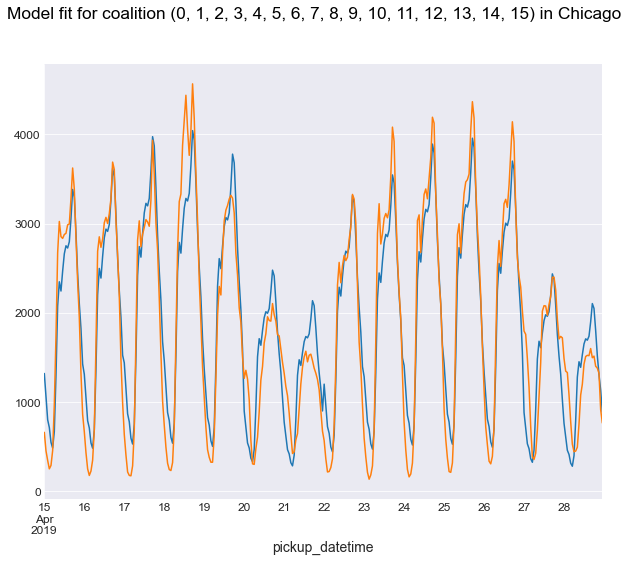

In [3]:
M.initialize()
plotPrediction(M.getSources())

You can also launch any prediction considering partial information, by feeding the model by using only part of the companies as an input. Please note that this model does not scale up the predictions, and consequently is not accurate in terms of absolute value of rides, but it is quite accurate when guessing the busy and valley hours.

Initializing SARIMA model with input params
Loading demand from files
Cosine similarity: 0.9827385280427458
Numerical similarity: 0.5625621983482492
Correlation: 0.9454111477860103
Relative SSE (-): -0.46887382522475035


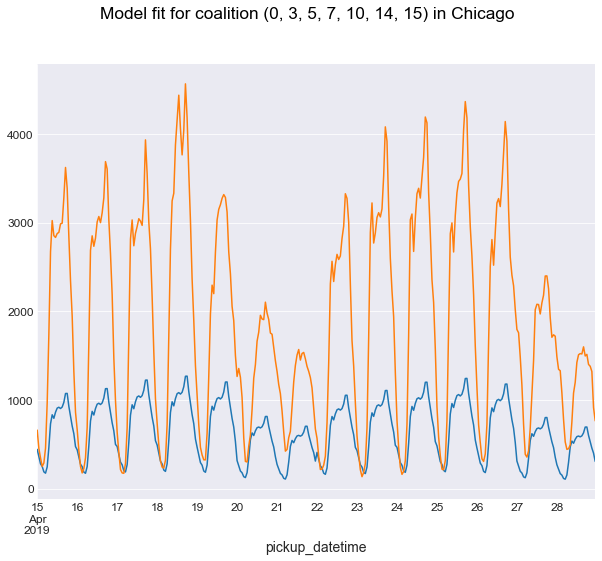

In [4]:
sampleTuple = (0,3,5,7,10,14,15)
plotPrediction(sampleTuple)

# Using the framework with the SARIMA model

To use the framework you need to set up a value-based evaluation framework, which requires i) a combiner, ii) a model (SARIMA in this case), and iii) a value function (CosSim in this case).

In [5]:
import vbdeFramework as fw
# Sets up the environment
c = M.vbPredCombiner() # Void combiner returns the tuple K it uses as a parameter
print("Sources: " + str(c.getSources()))
m = M.vbSARIMAmodel() # Set up a SARIMA model
v = M.vbPredCosSim() # Sets up the value function as an Euclidean similarity metric

# Creates the Framework
vbdeSARIMA = fw.vbdeFramework(c, m, v)

# Get some results to see if it works:
print("Accuracy for all sources: " + str(vbdeSARIMA.evaluateTuple(M.getSources())))
print("Accuracy for sample tuple: " + str(vbdeSARIMA.evaluateTuple(sampleTuple)))

Sources: (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15)
Initializing SARIMA model with input params
Loading demand from files
Accuracy for all sources: 0.9841213865134131
Accuracy for sample tuple: 0.9827385280427458


The vbde will store in the vS buffer the information about previous executions of the algorithm, so that in future calls, it is able to retrieve it directly without executing the model. The following lines will execute immediately without a need to fit and calculate a prediction of the SARIMA model (note the execution takes less time than the previous one). This is designed for models that takes a lot of time to execute. This buffering feature can be deactivated by setting vbdeFramework .i_vSbuffer parameter to False, ideally when calling the constructor.

In [69]:
print(vbdeSARIMA.vS)
print(vbdeSARIMA.evaluateTuple(M.getSources()))
print(vbdeSARIMA.evaluateTuple(sampleTuple))

s
(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15)    0.984121
(0, 3, 5, 7, 10, 14, 15)                                  0.982739
Name: v(S), dtype: float64
None
None


You can also import old executions to save in exec time

In [61]:
try:
    vbdeSARIMA.importVSFile("vS SARIMA.xlsx")
except:
    pass

# Using the framework with a toy model

In a similar way, you can use the framework with another module. We are going to use a simple count toy model with the vbdeFramework.

The count model returns the number of sources belonging in a set $N = \{0, 1, ..., |N|-1\}$ that are present in an input set $K$. For instance, for the set of sources K = \{0, 1, 2, 3\} it returns $\hat{d}(K) = 4$. This model tries to calculate the total number of sources in N, obviously without knowing N. To calculate the accuracy of the prediction, we use Euclidean distance and define the value function as:

$a(x) = 1 - \frac{|x - \hat{d}(N)|)} {\hat{d}(N)}$, if $|x - \hat{d}(N)| \leq \hat{d}(N)$

$a(x) = 0$, if $|x - \hat{d}(N)| > \hat{d}(N)$

The following lines of code set up the framework and the value function for N = 10. Please note that in this case we ask the model not to use the internal buffer by setting i_vSbuffer to False.


In [62]:
import ToyModels as ToyM
# Sets up the environment
cCount = ToyM.vbdeVoidCombiner(10) # Void combiner returns the tuple K it uses as a parameter
mCount = ToyM.vbdeSizeModel() # Average Toy model
NCount = tuple(range(0,10)) # We set up 10 possible input sources. S_n_i = i
vCount = ToyM.vbdeEuclideanSM(len(NCount), len(NCount)) # Sets up the value function as an Euclidean similarity metric

# Creates the Framework
vbdeFwCount = fw.vbdeFramework(cCount, mCount, vCount, i_vSbuffer = False)


We can test the inputs and outputs of the model, in order to understand how it works.

In [63]:
# Get some results to see if it works:
sampleTupleCount = (0,1,2,3,4)
sampleAllSources = (0,1,2,3,4,5,6,7,8,9)

# Model results (in this case the voidcombiner does nothing)
print("Result of the count model for tuple " + str(sampleAllSources) + ":" + str(mCount.getModelOutput(sampleAllSources)))
print("Result of the count model for tuple " + str(sampleAllSources) + ":" + str(mCount.getModelOutput(sampleTupleCount)))

# Accuracy results
print("Accuracy for all sources: " + str(vbdeFwCount.evaluateTuple(sampleAllSources)))
print("Accuracy for sample tuple: " + str(vbdeFwCount.evaluateTuple(sampleTupleCount)))

Result of the count model for tuple (0, 1, 2, 3, 4, 5, 6, 7, 8, 9):10
Result of the count model for tuple (0, 1, 2, 3, 4, 5, 6, 7, 8, 9):5
Accuracy for all sources: 1.0
Accuracy for sample tuple: 0.5


Now we will use the valuation functions that will be part of the API, meaning functions that are able to provide a driver to the value of an individual source in a tuple for a specific model, or a or a percentage of it. Those functions are built in the framework, and use the underlying model to calculate valuations.

## Computing individual values of sources (v({i}) or just vi)
A first analysis that will be done is computing the individual values of the different information sources used in the SARIMA model. The output reflects the accuracy of the model when trained only with information from each source.

In [50]:
%%time
# Calculates individual values
print ("Individual values for the sources in the SARIMA model: ")
vbdeSARIMA.getIndividualValues([0,1,2,3,8,10])

Individual values for the sources in the SARIMA model: 
Wall time: 21.2 s


0     0.969400
1     0.983483
2     0.979014
3     0.973598
8     0.979512
10    0.982531
dtype: float64

As it can be seen in the buffer, the accuracy for individuals is stored in the framework so that it will not be necessary to calculate hereinafter.

In [12]:
print(vbdeSARIMA.vS)

s
(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15)    0.984121
(0, 3, 5, 7, 10, 14, 15)                                  0.982739
(0,)                                                      0.969400
(1,)                                                      0.983483
(2,)                                                      0.979014
(3,)                                                      0.973598
(4,)                                                      0.980456
(5,)                                                      0.974327
(6,)                                                      0.980533
(7,)                                                      0.980764
(8,)                                                      0.979512
(9,)                                                      0.986322
(10,)                                                     0.982531
(11,)                                                     0.967343
(12,)                                                     0.

There is also a parallelized execution of this function, that allows to speed up the execution. For that to work we need to set up a dask environment and clear the buffer to see the differences between serial and parallelized executions.

In [52]:
from dask.distributed import Client
client = Client() # Stores always a copy of the dask client - apart from the one in config
config.daskClient = client # Link to the dask client to be used in the framework
vbdeSARIMA.clearBuffer()

In [14]:
%%time
# Calculates individual values
print ("Individual values for the sources in the SARIMA model: ")
vbdeSARIMA.getIndividualValuesParallel(client, M.WorkerProcess_init, M.getSources())

Individual values for the sources in the SARIMA model: 
Wall time: 22.5 s


0     0.969400
1     0.983483
2     0.979014
3     0.973598
4     0.980456
5     0.974327
6     0.980533
7     0.980764
8     0.979512
9     0.986322
10    0.982531
11    0.967343
12    0.984726
13    0.973926
14    0.976538
15    0.973055
dtype: float64

Using 4 workers on a i7 laptop the time to execute the valuation is divided by 3.

# Computing LOO values
LOO values return the accuracy lost by removing individual sources from the training data of a certain problem. LOOi = v(N) - v(N-{i})
In a similar way we are able to paralelize the execution of the computation of LOO values for each source i, which is the difference between v(N) and v(N-{i}). The following function does it using a single thread:

In [64]:
%%time
# Calculates individual values
print ("LOO values for the sources in the SARIMA model: ")
vbdeSARIMA.getLOOValues([0,1,2,3,8,10])

LOO values for the sources in the SARIMA model: 
Wall time: 29.3 s


0    -0.000389
1     0.003893
2     0.000201
3     0.000997
8    -0.000072
10    0.000067
dtype: float64

The buffer in the model already stores the information about previous executions, reducing the time needed in future executions.

In [16]:
vbdeSARIMA.vS

s
(0,)                                                      0.969400
(4,)                                                      0.980456
(8,)                                                      0.979512
(12,)                                                     0.984726
(1,)                                                      0.983483
(5,)                                                      0.974327
(9,)                                                      0.986322
(13,)                                                     0.973926
(2,)                                                      0.979014
(6,)                                                      0.980533
(10,)                                                     0.982531
(14,)                                                     0.976538
(3,)                                                      0.973598
(7,)                                                      0.980764
(11,)                                                     0.

There is a parallelized version of the calculation of LOO, similar to the one of individual values. Workers calculate the different models and accuracies in parallel significantly reducing the execution time.

In [17]:
%%time
vbdeSARIMA.clearBuffer()
vbdeSARIMA.getLOOValuesParallel(client, M.WorkerProcess_init, M.getSources())

Wall time: 24.1 s


0    -0.000320
1     0.000838
2     0.000126
3     0.000201
4    -0.000003
5     0.092373
6     0.000100
7     0.000466
8    -0.000047
9     0.000370
10    0.000072
11   -0.000382
12    0.000753
13   -0.001466
14    0.000211
15   -0.000066
dtype: float64

As it can be seen from the execution times, the parallelization of the execution reduces close one-third the execution time of a LOO estimation of a set of sources.

# Computing Shapley values

Establishing the individual player contribution to a collaborative game has long been a central problem of cooperative game theory. To this end, Shapley proposed that a players value should be proportional to their average marginal contribution to any coalition they may join \cite{Winter02}.

Let $N = \{n_1, n_2, ..., n_{|N|} \}$ be a set of players and $S_N$ be the aggregate data of $N$, with a value $v(S_N)$. The \textit{Shapley value} is a uniquely determined vector of the form $(\phi_1(v),..., \phi_{|N|}(v))$, where the element representing player $n_i$ is given by

\begin{equation}
\phi_{n_i}(v) = \frac{1}{|N|!} \sum_{\pi \in \Pi} [v(S_{(\pi, i)}) - v(S_{(\pi, i) \setminus n_i})],
\label{shapley_eq}
\end{equation}

where $\pi$ is a permutation representing the arrival order of the elements in set $N$, while $S_{(\pi, n_i)}$ represents the set of players that have arrived into the system before player $n_i$.

In [70]:
%%time
vbdeSARIMA.calculateSV_parallel(client, M.WorkerProcess_init, (0,1,2,3,4))

Raw parallel SV calculation for the following sources: 

(0, 1, 2, 3, 4)
Calculating Shapley value for source 0
Calculating SV(S) for individual contributions
Calculating SV(S) for coalitions of level 1
Calculating SV(S) for coalitions of level 2
Calculating SV(S) for coalitions of level 3
Calculating SV(S) for coalitions of level 4
Calculating Shapley value for source 1
Calculating SV(S) for individual contributions
Calculating SV(S) for coalitions of level 1
Calculating SV(S) for coalitions of level 2
Calculating SV(S) for coalitions of level 3
Calculating SV(S) for coalitions of level 4
Calculating Shapley value for source 2
Calculating SV(S) for individual contributions
Calculating SV(S) for coalitions of level 1
Calculating SV(S) for coalitions of level 2
Calculating SV(S) for coalitions of level 3
Calculating SV(S) for coalitions of level 4
Calculating Shapley value for source 3
Calculating SV(S) for individual contributions
Calculating SV(S) for coalitions of level 1
Calculating

0    0.193396
1    0.201920
2    0.196799
3    0.195874
4    0.197590
dtype: float64

In this specific example, by only using the information of each source in the set (0,1,2,3,4) we are able to reconstruct the demand, and consequently the value of each source is similar. The Shapley value is approximately 1/5.

The main problem of Shapley value raw calculation is the its execution time is $O(2^{|N|})$, so that approximations are needed in order to accelerate the execution of the algorithm. To circumvent this problem, a series of approximation algorithms are provided in the package, namely the following:
* (Truncated) Montecarlo ((T)MC)
* (Truncated) Random sampling ((T)RS)
* (Truncated) Structured sampling ((T)SS)

Truncation value (MC, SS, RS) specifies an accuracy threshold (float in [0,1]) that, when exceeded while evaluating a permutation of users, will assume the rest of users. If truncation value is equal to 1, non-truncated versions of MC, SS or RS algorithms will be run in order to get the value of user data.
Depth parameter (SS, RS) defines the number of permutations (integer) used to approximate Shapley value in sampling algorithms. In the case of using the SS, this value will be automatically rounded to the closest multiple of the total number of individuals in S’.
Stop condition (MC) defines the minimum percentage variation of Shapley value (float in [0,1]) in the last executions required to continue evaluating new permutations
The precision of any Shapley value approximation algorithm (MC, SS, RS) is given by the combination of the last three parameters. The lower truncation value, the shallower depth or the higher percentage in the stop condition will lead to coarser approximations.

## Using (truncated) structured sampling

The following lines of code are used to start a parallelized version of Shapley value approximation using truncated structure sampling which was found to be the best approximation to SV in prediction problems (see  [Computing the Value of Spatio-Temporal Data in Wholesale and Retail Data Marketplaces](https://arxiv.org/abs/2002.11193)). The buffer is cleared before calling the function to compare with raw Shapley value in terms of time to execute.

In [77]:
%%time
vbdeSARIMA.clearBuffer()
vbdeSARIMA.getTSS_parallel(client, M.WorkerProcess_init, [0,1,2,3,8,10], 16, 0.95)

Wall time: 9.45 s


(0     0.159901
 1     0.162224
 2     0.161487
 3     0.160593
 8     0.161569
 10    0.162067
 Name: SV TSS, dtype: float64,
 0     (0, 1, 2, 8, 3, 10)
 1     (1, 8, 0, 10, 2, 3)
 2     (8, 10, 1, 3, 0, 2)
 3     (10, 3, 8, 2, 1, 0)
 4     (3, 2, 10, 0, 8, 1)
              ...         
 91    (2, 1, 10, 8, 0, 3)
 92    (1, 8, 2, 3, 10, 0)
 93    (8, 3, 1, 0, 2, 10)
 94    (3, 0, 8, 10, 1, 2)
 95    (0, 10, 3, 2, 8, 1)
 Length: 96, dtype: object,
 6)

We are able to execute the random sampling for 16 sources in 1/3 of the time it takes to calculate the exact Shapley value for 5 sources, in this specific example.

# Using (random) structured sampling

The following lines of code allow to use a random sampling approximation to the Shapley value (see  [Computing the Value of Spatio-Temporal Data in Wholesale and Retail Data Marketplaces](https://arxiv.org/abs/2002.11193)). Whereas in TSS we design a suitable set of permutations to approximate SV in the most effective and efficient way possible, in RSS algorithms those permutations are randomly set. We will clear the buffer for the calculation to show comparable execution times.

In [78]:
%%time
vbdeSARIMA.clearBuffer()
vbdeSARIMA.getTRS_parallel(client, M.WorkerProcess_init, [0,1,2,3,8,10], 16, 0.95)

RSS parallel calculation for 6 companies: 

0     [1, 2, 10, 0, 3, 8]
1     [0, 8, 10, 2, 1, 3]
2     [3, 2, 0, 8, 10, 1]
3     [1, 3, 2, 10, 0, 8]
4     [8, 1, 2, 3, 10, 0]
             ...         
91    [1, 8, 10, 0, 2, 3]
92    [2, 0, 1, 3, 8, 10]
93    [8, 3, 2, 1, 10, 0]
94    [1, 0, 2, 3, 10, 8]
95    [8, 1, 3, 10, 2, 0]
Length: 96, dtype: object
Wall time: 9.45 s


(0     0.139913
 1     0.233197
 2     0.151394
 3     0.170631
 8     0.161569
 10    0.111421
 Name: SV TSS, dtype: float64,
 0     [1, 2, 10, 0, 3, 8]
 1     [0, 8, 10, 2, 1, 3]
 2     [3, 2, 0, 8, 10, 1]
 3     [1, 3, 2, 10, 0, 8]
 4     [8, 1, 2, 3, 10, 0]
              ...         
 91    [1, 8, 10, 0, 2, 3]
 92    [2, 0, 1, 3, 8, 10]
 93    [8, 3, 2, 1, 10, 0]
 94    [1, 0, 2, 3, 10, 8]
 95    [8, 1, 3, 10, 2, 0]
 Length: 96, dtype: object,
 6)

# Using (Truncated) Montecarlo approximation to SV

Another variant of approximation to Shapley value is Truncated Montecarlo algorithms (TMC). TMC algorithms evaluate new permutations and average the marginal value of each source in all processed permutations until a stop condition is met, typically that SV approximations do not change above a certain threshold (e.g. 5%) for a number of executions. The algorithm takes as inputs the following parameter
- Set of players N for which to calculate the SV
- A minimum number of permutations evaluated: tmin. Regardless SV variation, the algorithm will evaluate at least tmin.
- A maximum number of permutations evaluated: tmax. If tmax permutations are evaluated, the algorithm stops regardless the SV has converged or not.
- A maximum threshold variation in SVs: SV_var_threshold. If any element in N SV 
- Absolute or relative threshold comparison (True/False). If True, the maximum threshold will be interpreted as an absolute variation in the SV. If false, it will be interpreted as a relative threshold variation.
        
The next lines of code show how to use our implementation of TMC to calculate an approximation to SV.

In [8]:
%%time
vbdeSARIMA.clearBuffer()

SVpred = vbdeSARIMA.getSV_TMC([0,1,2,3,8,10], 16, 400, 0.05, False, 0.95)

SV calculation using TMC for 6 companies
Processing permutation 1: [3, 8, 10, 1, 0, 2]
Processing permutation 2: [0, 2, 10, 3, 1, 8]
Processing permutation 3: [1, 0, 3, 2, 10, 8]
Processing permutation 4: [3, 8, 2, 0, 10, 1]
Processing permutation 5: [1, 3, 10, 2, 0, 8]
Processing permutation 6: [1, 8, 10, 0, 2, 3]
Processing permutation 7: [2, 0, 1, 10, 8, 3]
Processing permutation 8: [1, 3, 0, 2, 10, 8]
Processing permutation 9: [8, 1, 3, 10, 2, 0]
Processing permutation 10: [8, 10, 1, 2, 0, 3]
Processing permutation 11: [1, 8, 2, 0, 3, 10]
Processing permutation 12: [10, 1, 0, 8, 3, 2]
Processing permutation 13: [10, 3, 1, 2, 8, 0]
Processing permutation 14: [0, 2, 10, 3, 8, 1]
Processing permutation 15: [2, 1, 0, 8, 10, 3]
Processing permutation 16: [8, 10, 3, 1, 0, 2]
Processing permutation 17: [0, 10, 2, 3, 1, 8]
SV threshold achieved after processing 17 permutations
6 new model trainning and executions were needed
   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16

At any moment, you can save previous executions of the model on the sources in order to save in future execution time. vbdeFramework can load them in the buffer and will look up the buffer before training and executing the model again for a same set of users.

In [47]:
vbdeSARIMA.exportVSFile("vS SARIMA.xlsx")

Executing the TMC again will most likely result in vbdeFramework getting results faster (please note that TMC has some degree of randomness, so it may take longer because of different reasons, e.g., because the permutations chosen were very different and the vbdeFramework needed to compute more of them):

In [48]:
%%time
#vbdeSARIMA.clearBuffer()

SVpred = vbdeSARIMA.getSV_TMC(M.getSources(), 16, 400, 0.01, False, 0.98)

SV calculation using TMC for %i companies: 
 16
Processing permutation 1: [12, 8, 14, 10, 6, 2, 1, 15, 7, 9, 5, 13, 0, 11, 4, 3]
Processing permutation 2: [8, 2, 7, 10, 15, 12, 11, 3, 5, 1, 9, 6, 4, 0, 14, 13]
Processing permutation 3: [9, 14, 3, 5, 12, 1, 7, 6, 2, 8, 15, 13, 0, 11, 10, 4]
Processing permutation 4: [10, 1, 9, 12, 7, 11, 13, 2, 8, 0, 14, 6, 15, 3, 4, 5]
Processing permutation 5: [9, 11, 2, 1, 0, 13, 6, 14, 4, 15, 10, 12, 3, 8, 7, 5]
Processing permutation 6: [14, 5, 10, 0, 2, 12, 9, 6, 4, 13, 15, 1, 3, 8, 7, 11]
Processing permutation 7: [14, 4, 11, 13, 1, 12, 6, 7, 8, 9, 3, 2, 15, 10, 0, 5]
Processing permutation 8: [9, 4, 3, 13, 14, 8, 0, 12, 5, 2, 15, 7, 6, 10, 11, 1]
Processing permutation 9: [10, 2, 3, 0, 13, 14, 5, 8, 9, 11, 1, 12, 15, 7, 6, 4]
Processing permutation 10: [8, 10, 6, 11, 2, 0, 1, 15, 5, 14, 12, 7, 9, 4, 3, 13]
Processing permutation 11: [9, 0, 4, 14, 6, 12, 3, 7, 8, 15, 10, 11, 5, 2, 13, 1]
Processing permutation 12: [10, 3, 11, 2, 6, 12, 0, 8, 9, 4

C:\Users\santi\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Processing permutation 19: [12, 2, 7, 6, 4, 10, 1, 5, 14, 8, 0, 9, 15, 13, 3, 11]
Processing permutation 20: [9, 5, 7, 8, 3, 15, 12, 10, 6, 4, 14, 13, 1, 0, 11, 2]
Processing permutation 21: [12, 8, 5, 9, 4, 0, 10, 6, 14, 1, 7, 13, 15, 11, 3, 2]
Processing permutation 22: [7, 15, 13, 3, 8, 0, 10, 9, 14, 11, 1, 5, 12, 4, 2, 6]
Processing permutation 23: [7, 14, 10, 3, 2, 4, 11, 9, 15, 13, 12, 5, 1, 0, 8, 6]
Processing permutation 24: [15, 1, 0, 6, 13, 12, 8, 14, 5, 9, 3, 10, 11, 2, 4, 7]
Processing permutation 25: [9, 6, 7, 14, 11, 1, 10, 3, 2, 15, 12, 5, 8, 13, 4, 0]
Processing permutation 26: [14, 11, 1, 5, 3, 2, 0, 9, 10, 7, 12, 6, 13, 15, 8, 4]
Processing permutation 27: [5, 11, 7, 13, 9, 15, 14, 10, 8, 4, 12, 3, 2, 1, 6, 0]
Processing permutation 28: [15, 13, 9, 12, 5, 10, 3, 14, 0, 7, 11, 8, 1, 6, 2, 4]
Processing permutation 29: [6, 13, 5, 4, 2, 1, 9, 15, 11, 14, 12, 7, 3, 0, 8, 10]
Processing permutation 30: [7, 11, 5, 4, 13, 9, 15, 6, 1, 2, 8, 3, 14, 12, 0, 10]
Processing permu

Checking the results:

In [80]:
SVpred

0     0.120949
1     0.210919
2     0.220734
3     0.061272
8     0.159858
10    0.209316
Name: SV Monte Carlo, dtype: float64